In [183]:
import ee
from pprint import pprint
from IPython.display import display
from IPython.display import Image

In [184]:
ee.Initialize()

In [185]:
def plot_image(image):
  viz = image.visualize(bands=['water'], palette=['white', 'red', 'blue'])
  im = Image(ee.data.getThumbnail({'image' : viz.serialize()}))
  display(im)

In [186]:
dataset_path = 'LANDSAT/LC08/C01/T1_TOA'
path = 3
row = 69
start_date = '2016-01-01'
end_date = '2017-01-01'

collection = ee.ImageCollection(dataset_path) \
    .filter(ee.Filter.eq('WRS_PATH', path)) \
    .filter(ee.Filter.eq('WRS_ROW', row)) \
    .filterDate(start_date, end_date)

In [187]:
cloud_thresh = ee.Number(25.0)
filtered = collection.filterMetadata('CLOUD_COVER', 'less_than', cloud_thresh)

In [188]:
img = ee.Image(filtered.sort('CLOUD_COVER').first())
url = img.getThumbUrl()

In [189]:
Image(url=url)

In [190]:
water = ee.ImageCollection('JRC/GSW1_0/MonthlyHistory')
cur = ee.Image(water.filter(ee.Filter.eq('month', 6)).first())
clipped = cur.clip(img.geometry())
stacked = img.addBands(clipped)

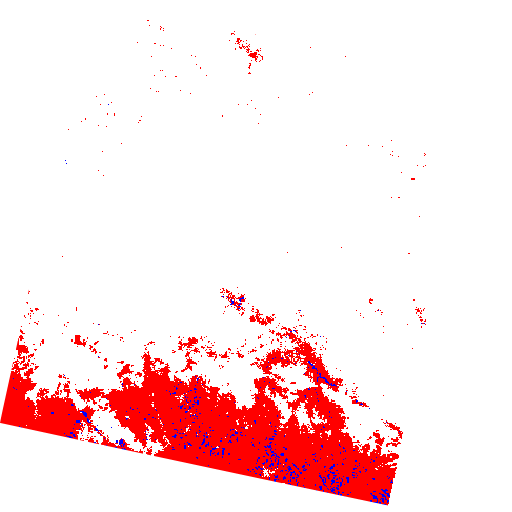

In [191]:
plot_image(clipped)

In [192]:
training = stacked.sample(numPixels=1000, seed=0).filter(ee.Filter.neq('water', 0))
validation = stacked.sample(numPixels=1000, seed=1).filter(ee.Filter.neq('water', 0))

In [193]:
classifier = ee.Classifier.svm().train(training, 'water')

In [194]:
classified = img.classify(classifier)

In [195]:
validated = validation.classify(classifier)
accuracy = validated.errorMatrix('water', 'classification')
print(accuracy.accuracy().getInfo())

0.00819672131148


In [197]:
url = classified.getThumbUrl()
Image(url=url)